In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from boruta import BorutaPy

In [115]:
df = pd.read_csv('../data/input/client_attrition_train.csv')
df.sample(20)


,customer_id,customer_age,customer_sex,customer_number_of_dependents,customer_education,customer_civil_status,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,...,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status
4326,871036,45.0,M,4,Graduate,Single,80-120K,40,6363.0,Blue,...,3,0,1029,5334.0,0.838,1542.0,16,1.286,0.162,open
430,647880,50.0,F,1,Doctorate,Married,Unknown,40,2492.0,Blue,...,3,1,1410,1082.0,0.835,4374.0,75,0.974,0.566,open
547,987884,47.0,M,3,Post-Graduate,Divorced,60-80K,37,5731.0,Blue,...,3,0,1577,4154.0,0.657,1554.0,26,0.444,0.275,open
165,956848,47.0,F,2,Graduate,Married,Unknown,36,18799.0,Blue,...,3,2,2517,16282.0,0.813,2315.0,52,0.625,0.134,closed
9790,220286,49.0,M,0,Doctorate,Married,60-80K,39,19719.0,Blue,...,6,3,1395,18324.0,0.565,3572.0,73,0.738,0.071,open
3442,296833,40.0,NaN,3,Unknown,Single,60-80K,34,9594.0,Blue,...,2,1,2517,7077.0,0.945,14213.0,100,0.786,0.262,open
6273,618427,49.0,F,2,Unknown,Single,Unknown,41,5984.0,Blue,...,3,4,0,5984.0,0.551,NaN,42,0.556,0.000,closed
8786,198127,43.0,F,3,Unknown,Divorced,below 40K,30,2905.0,Blue,...,2,1,2079,826.0,0.789,4444.0,84,0.909,0.716,open
3216,919378,31.0,F,2,Unknown,Married,Unknown,20,8149.0,Blue,...,1,2,0,8149.0,0.331,808.0,30,0.111,0.000,closed
6484,205902,NaN,M,3,Post-Graduate,Single,60-80K,35,13048.0,Blue,...,3,0,1954,11094.0,1.139,1170.0,24,0.846,0.150,open


In [116]:
df['customer_salary_range']

0           40-60K
1        below 40K
2          80-120K
3        below 40K
4          80-120K
           ...    
10122       40-60K
10123      Unknown
10124       60-80K
10125    below 40K
10126       40-60K
Name: customer_salary_range, Length: 10127, dtype: object

In [117]:
df.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

,mean,std,min,50%,max
customer_id,550508.987854,261237.656234,100069.0,552548.000,999911.000
customer_age,46.317900,8.001227,26.0,46.000,73.000
customer_number_of_dependents,2.346203,1.298908,0.0,2.000,5.000
customer_relationship_length,35.928409,7.986416,13.0,36.000,56.000
customer_available_credit_limit,10036.343784,17629.707395,1438.3,4696.000,310644.000
total_products,4.147329,3.183477,1.0,4.000,36.000
period_inactive,2.341167,1.010622,0.0,2.000,6.000
contacts_in_last_year,2.455317,1.106225,0.0,2.000,6.000
credit_card_debt_balance,1162.814061,814.987335,0.0,1276.000,2517.000
remaining_credit_limit,7469.139637,9090.685324,3.0,3474.000,34516.000


In [118]:
df.describe(include=[np.object_]).transpose().drop("count", axis=1)

,unique,top,freq
customer_sex,2,F,4838
customer_education,7,Graduate,3128
customer_civil_status,4,Married,4687
customer_salary_range,6,below 40K,3327
credit_card_classification,4,Blue,9436
account_status,2,open,8500


In [119]:
df.dtypes

customer_id                          int64
customer_age                       float64
customer_sex                        object
customer_number_of_dependents        int64
customer_education                  object
customer_civil_status               object
customer_salary_range               object
customer_relationship_length         int64
customer_available_credit_limit    float64
credit_card_classification          object
total_products                       int64
period_inactive                      int64
contacts_in_last_year                int64
credit_card_debt_balance             int64
remaining_credit_limit             float64
transaction_amount_ratio           float64
total_transaction_amount           float64
total_transaction_count              int64
transaction_count_ratio            float64
average_utilization                float64
account_status                      object
dtype: object

In [120]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
customer_sex,1018,10.052335
customer_salary_range,681,6.724598
customer_age,624,6.161746
total_transaction_amount,407,4.018959


In [121]:
print(df['customer_salary_range'].unique())

['40-60K' 'below 40K' '80-120K' 'Unknown' '60-80K' nan '120K and more']


In [122]:
df['customer_sex'] = df['customer_sex'].map({'M': 1, 'F': 0})
salary_mapping = {
    'below 40K': 1,
    '40-60K': 2,
    '60-80K': 3,
    '80-120K': 4,
    '120K and more': 5
}
df['customer_salary_range'] = df['customer_salary_range'].map(salary_mapping)

education_mapping = {
    'Unknown': np.nan,
    'Uneducated': 1,
    'High School': 2,
    'College': 3,
    'Graduate': 4,
    'Post-Graduate': 5,
    'Doctorate': 6
}
df['customer_education'] = df['customer_education'].map(education_mapping)

df['customer_civil_status'].replace('Unknown', pd.NA, inplace=True)
df_encoded = pd.get_dummies(df['customer_civil_status'], drop_first=True)
df_encoded.rename(columns={'Divorced': 'customer_divorced', 'Married': 'customer_married'}, inplace=True)
df = pd.concat([df, df_encoded], axis=1)

classification_mapping = {
    'Blue': 1,
    'Silver': 2,
    'Gold': 3,
    'Platinum': 4
}
df['credit_card_classification'] = df['credit_card_classification'].map(classification_mapping)
df['account_status'] = df['account_status'].map({'open': 1, 'closed': 0})


In [123]:
df.columns

Index(['customer_id', 'customer_age', 'customer_sex',
       'customer_number_of_dependents', 'customer_education',
       'customer_civil_status', 'customer_salary_range',
       'customer_relationship_length', 'customer_available_credit_limit',
       'credit_card_classification', 'total_products', 'period_inactive',
       'contacts_in_last_year', 'credit_card_debt_balance',
       'remaining_credit_limit', 'transaction_amount_ratio',
       'total_transaction_amount', 'total_transaction_count',
       'transaction_count_ratio', 'average_utilization', 'account_status',
       'customer_married', 'Single'],
      dtype='object')

In [124]:
x_col = ['customer_age', 'customer_sex',
       'customer_number_of_dependents', 'customer_education',
       'customer_salary_range',
       'customer_relationship_length', 'customer_available_credit_limit',
       'credit_card_classification', 'total_products', 'period_inactive',
       'contacts_in_last_year', 'credit_card_debt_balance',
       'remaining_credit_limit', 'transaction_amount_ratio',
       'total_transaction_amount', 'total_transaction_count',
       'transaction_count_ratio', 'average_utilization',
       'customer_married', 'Single']

In [125]:
y_col = ['account_status']

In [126]:
df = df.drop(['customer_civil_status','customer_id'], axis=1)

In [127]:
scaler = MinMaxScaler()
df.loc[:,x_col] = pd.DataFrame(scaler.fit_transform(df.loc[:,x_col]), columns = df.loc[:,x_col].columns)
df.loc[:,x_col].head()

C:\Users\micha\AppData\Local\Temp\ipykernel_33844\1474717536.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,x_col] = pd.DataFrame(scaler.fit_transform(df.loc[:,x_col]), columns = df.loc[:,x_col].columns)


,customer_age,customer_sex,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,total_products,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,customer_married,Single
0,0.255319,0.0,0.4,0.2,0.25,0.418605,0.000500,0.000000,0.085714,0.333333,0.666667,0.433453,0.014458,0.256108,0.031085,0.441860,0.044185,0.685686,1.0,0.0
1,0.425532,0.0,0.4,0.6,0.00,0.627907,0.016590,0.000000,0.114286,0.333333,0.333333,0.000000,0.190218,0.029732,0.008547,0.178295,0.013662,0.000000,0.0,0.0
2,0.361702,1.0,0.2,0.2,0.75,0.395349,0.106976,0.333333,0.000000,0.166667,0.500000,0.812475,0.940747,0.173683,0.030613,0.341085,0.025908,0.059059,1.0,0.0
3,0.425532,0.0,0.8,0.2,0.00,0.534884,0.003026,0.000000,0.114286,0.333333,0.166667,0.529201,0.030105,0.201943,0.032088,0.550388,0.054400,0.561562,1.0,0.0
4,0.297872,1.0,0.8,0.2,0.75,0.372093,0.037320,0.000000,0.057143,0.500000,0.333333,0.000000,0.375945,0.184869,0.116795,0.581395,0.043077,0.000000,0.0,1.0


In [128]:
imputer = KNNImputer(n_neighbors=5)
df.loc[:,x_col] = pd.DataFrame(imputer.fit_transform(df.loc[:,x_col]),columns = df.loc[:,x_col].columns)

In [129]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage


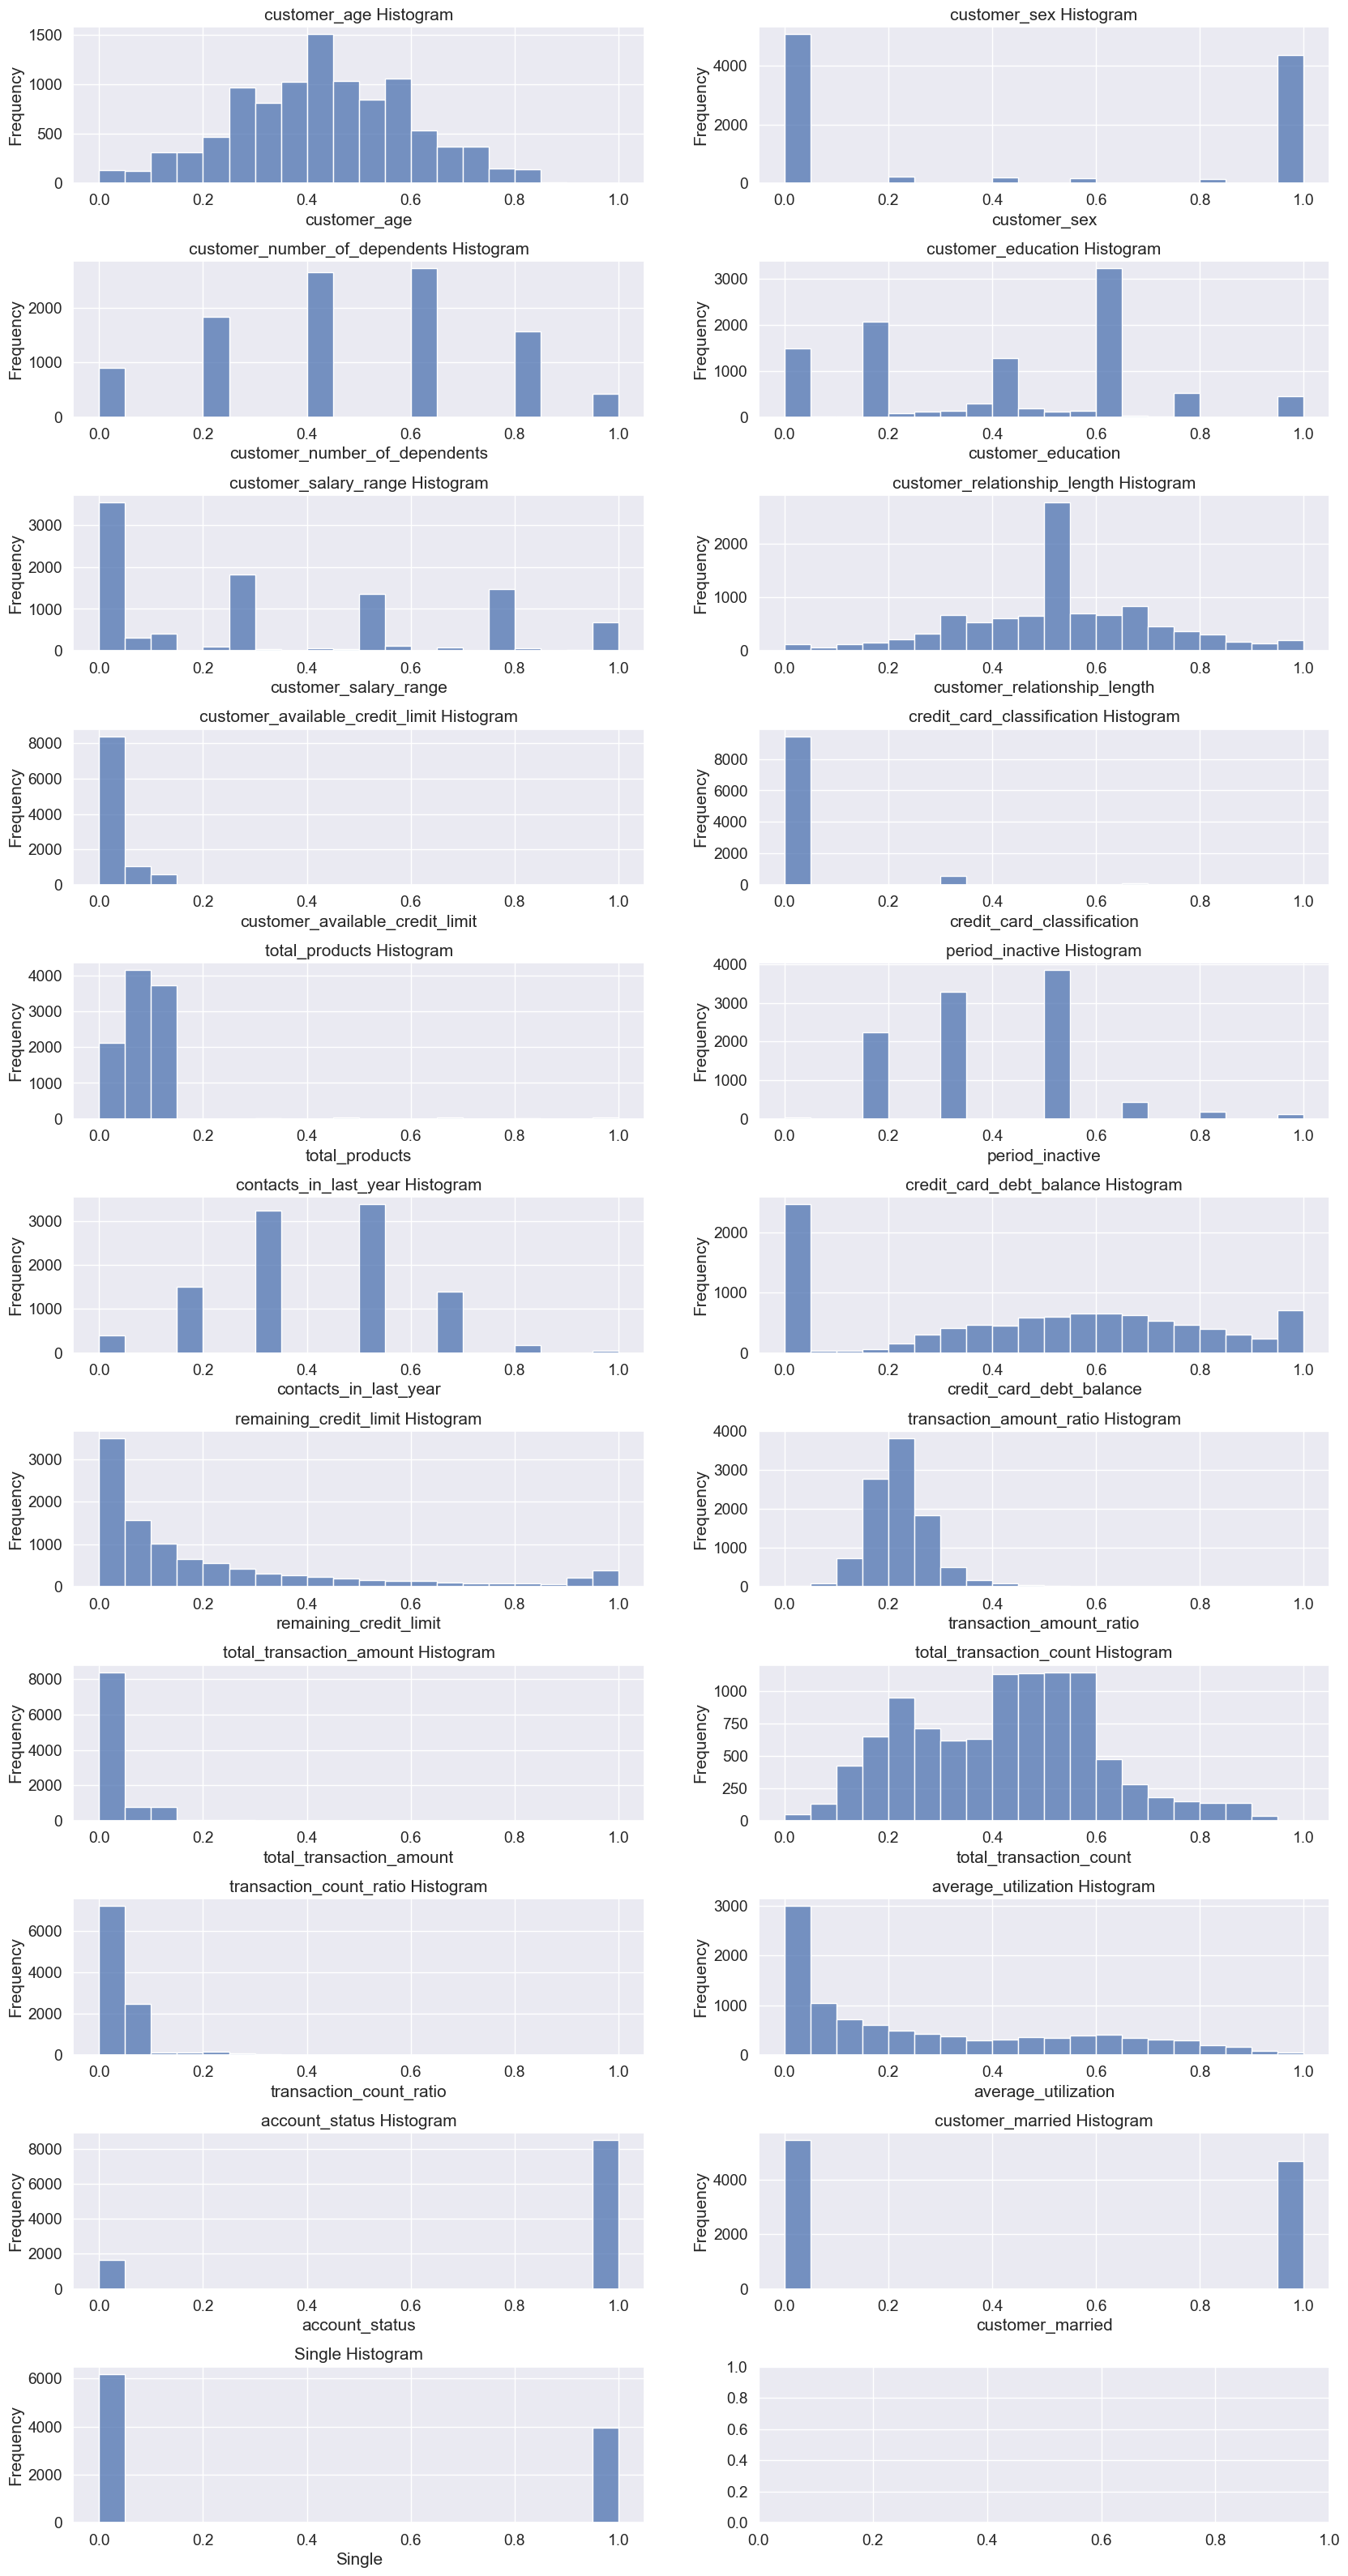

In [130]:
fig, axes = plt.subplots(ncols = 2, nrows =11, figsize=(20,40))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    sns.histplot(data=df[column].dropna(), ax=axes[i], bins=20)
    axes[i].set_title(column + " Histogram")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
plt.subplots_adjust(hspace=0.5) 
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

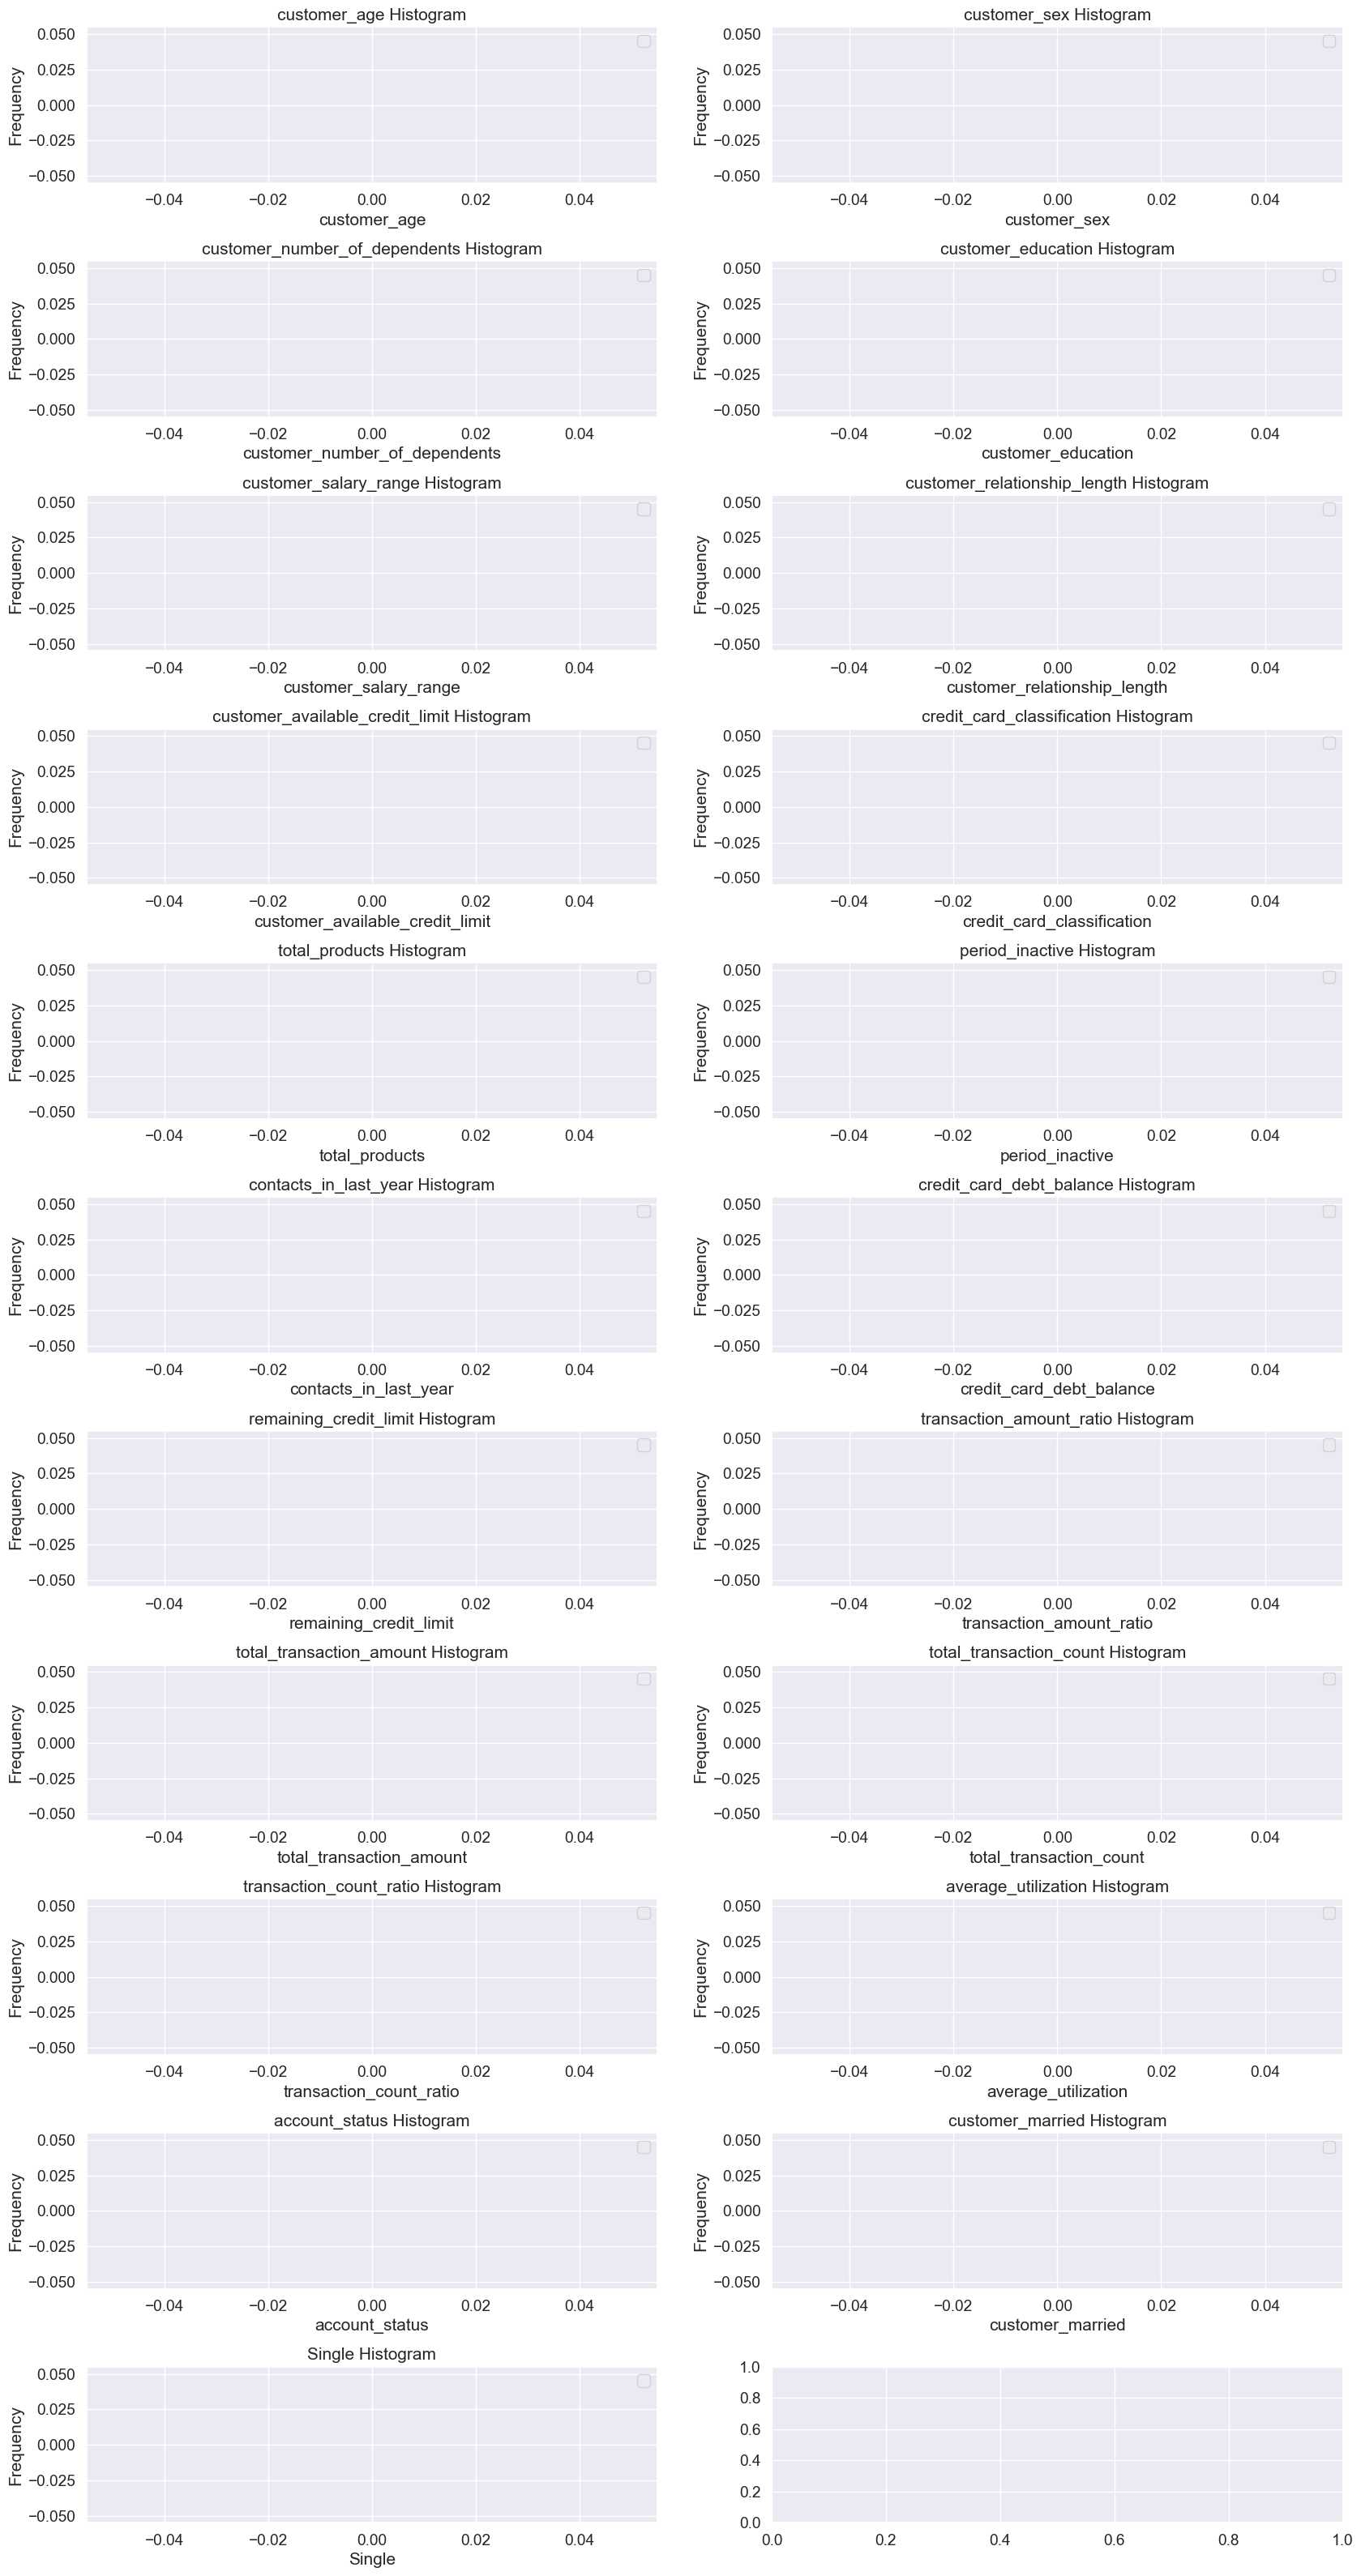

In [131]:
fig, axes = plt.subplots(ncols = 2, nrows =11, figsize=(20,40))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    ax = axes[i]
    sns.histplot(data=df[df['account_status'] == 'open'][column].dropna(), ax=ax, bins=20, alpha=0.7, label='Open')
    sns.histplot(data=df[df['account_status'] == 'closed'][column].dropna(), ax=ax, bins=20, alpha=0.7, label='Closed')

    ax.set_title(column + " Histogram")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.subplots_adjust(hspace=0.5) 
plt.show()



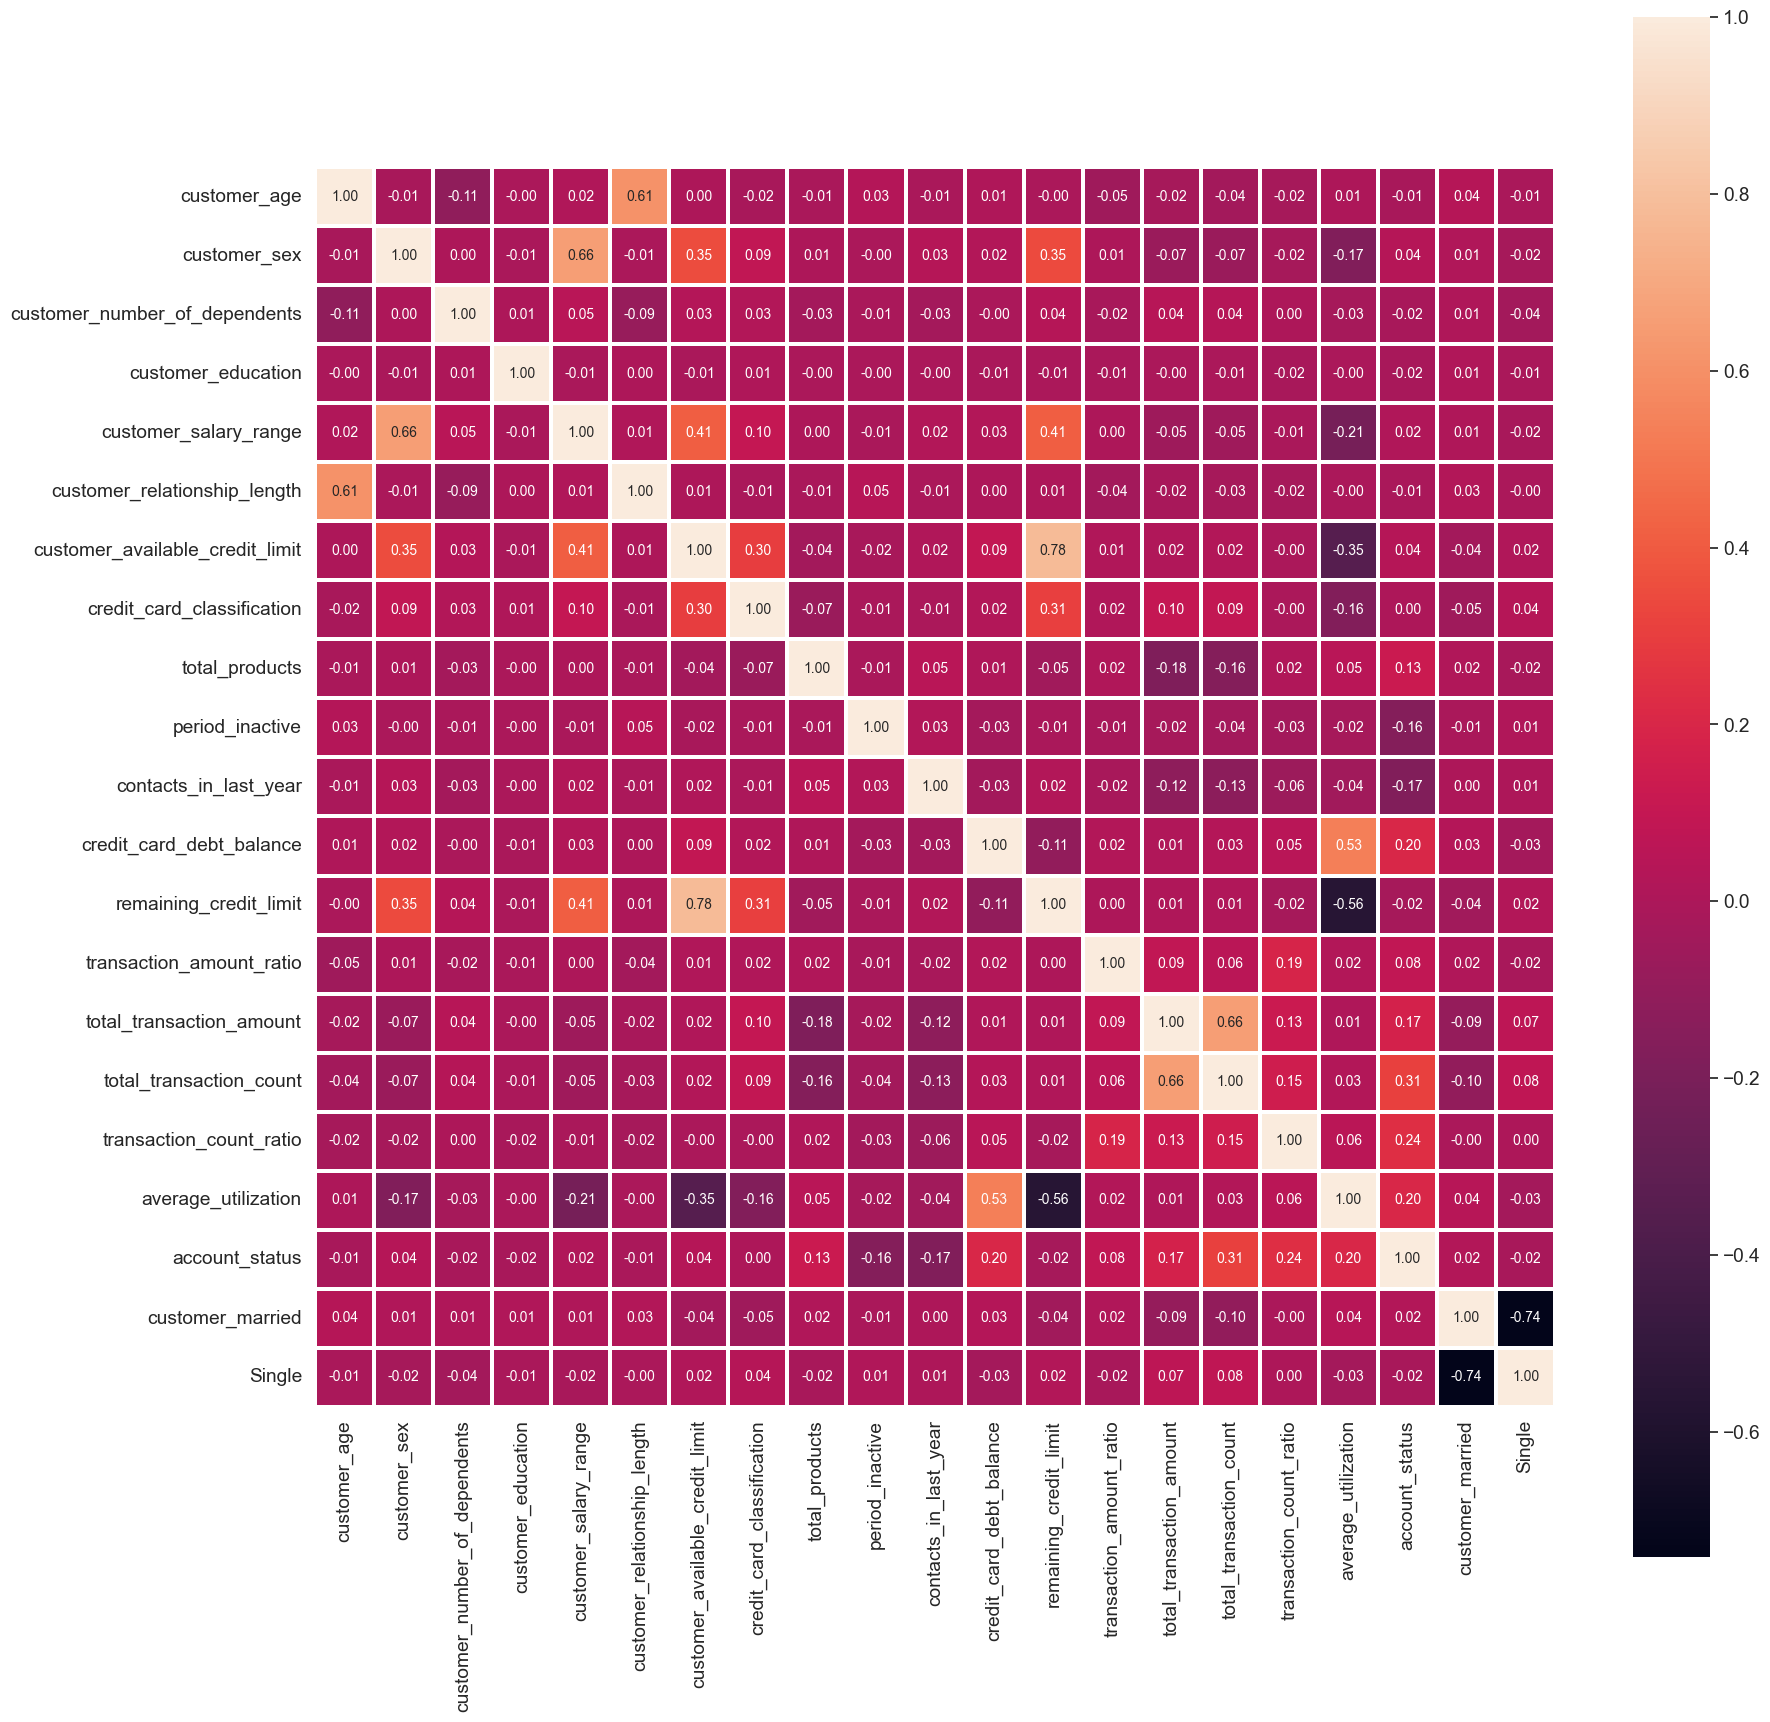

In [132]:
corr = df.corr("kendall")
foo = pd.DataFrame(corr.abs().unstack().sort_values(ascending=False))
#foo = foo[foo[0] != 1]
foo = foo[foo.duplicated() == False]
foo.head(10)

corr = df.corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

In [133]:
from scipy.stats import kendalltau

correlations = {}
for column in df.columns:
    if column != "account_status":
        corr, _ = kendalltau(df[column], df["account_status"])
        correlations[column] = corr
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

top_5 = correlation_df.head(5)
bottom_5 = correlation_df.tail(5)

print("Top 5 Correlations:")
print(top_5)

print("\nBottom 5 Correlations:")
print(bottom_5)



Top 5 Correlations:
                          Correlation
total_transaction_count      0.309061
transaction_count_ratio      0.235213
credit_card_debt_balance     0.201344
average_utilization          0.201005
total_transaction_amount     0.173698

Bottom 5 Correlations:
                               Correlation
customer_number_of_dependents    -0.018786
Single                           -0.019037
remaining_credit_limit           -0.022468
period_inactive                  -0.159147
contacts_in_last_year            -0.172018


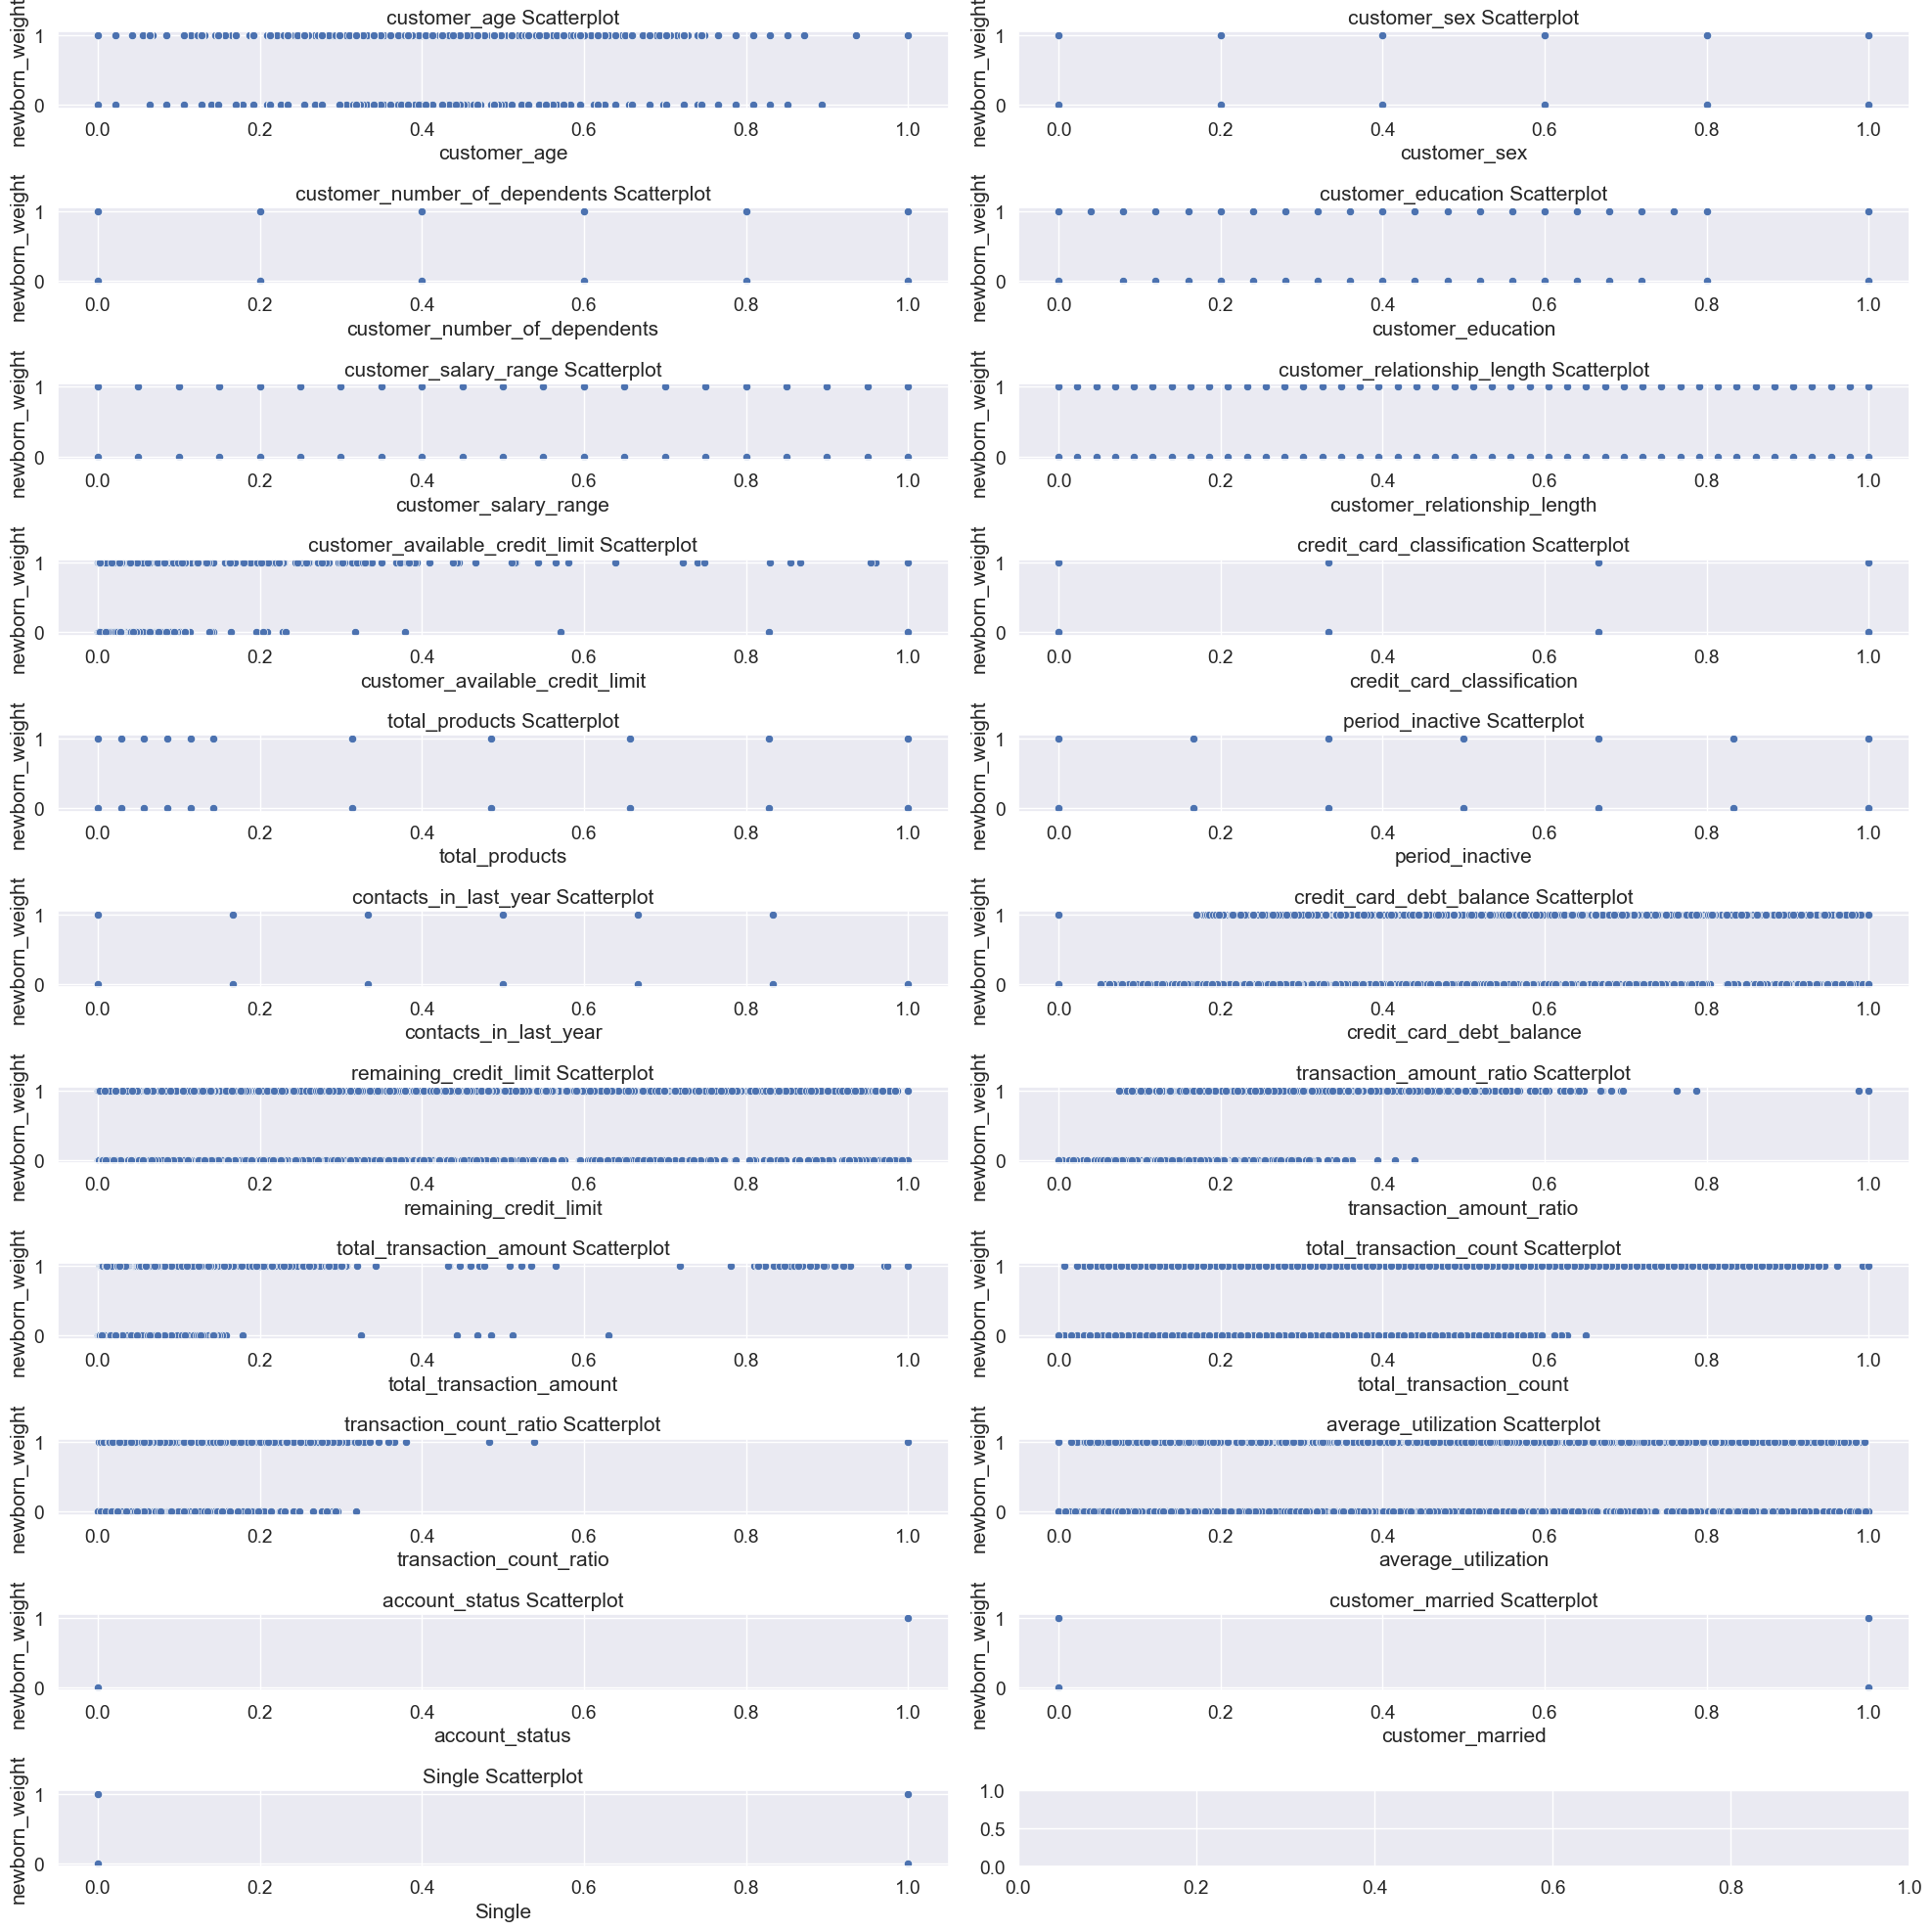

In [134]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='account_status', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

In [135]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs = -1)


In [136]:
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=50  # number of iterations to perform
)

In [137]:
df.loc[:,x_col].dtypes

customer_age                       float64
customer_sex                       float64
customer_number_of_dependents      float64
customer_education                 float64
customer_salary_range              float64
customer_relationship_length       float64
customer_available_credit_limit    float64
credit_card_classification         float64
total_products                     float64
period_inactive                    float64
contacts_in_last_year              float64
credit_card_debt_balance           float64
remaining_credit_limit             float64
transaction_amount_ratio           float64
total_transaction_amount           float64
total_transaction_count            float64
transaction_count_ratio            float64
average_utilization                float64
customer_married                   float64
Single                             float64
dtype: object

In [138]:
df.sample(19)

,customer_age,customer_sex,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,total_products,period_inactive,...,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status,customer_married,Single
3593,0.574468,1.0,0.8,0.20,1.00,0.651163,0.006348,0.000000,0.142857,0.500000,...,0.680572,0.048822,0.227554,0.012122,0.341085,0.019508,0.504505,1,1.0,0.0
8240,0.361702,0.0,0.6,0.20,0.00,0.534884,0.002829,0.000000,0.114286,0.500000,...,0.526420,0.028540,0.212835,0.038543,0.511628,0.049846,0.573574,1,0.0,1.0
4982,0.404255,0.0,0.8,0.80,0.25,0.511628,0.001331,0.000000,0.057143,0.833333,...,0.246722,0.035523,0.200765,0.031925,0.496124,0.041969,0.336336,1,0.0,1.0
5292,0.659574,1.0,0.4,0.20,0.50,0.790698,0.002619,0.000000,0.142857,0.500000,...,0.000000,0.065048,0.216367,0.033682,0.519380,0.033231,0.000000,1,0.0,1.0
7857,0.170213,0.4,0.4,0.40,0.20,0.209302,0.000623,0.000000,0.085714,0.333333,...,0.000000,0.047171,0.557256,0.021020,0.364341,0.068369,0.000000,1,1.0,0.0
3457,0.582979,0.0,0.4,0.60,0.00,0.790698,0.015875,0.000000,0.114286,0.500000,...,0.000000,0.183815,0.137180,0.005581,0.263566,0.023077,0.000000,1,0.0,1.0
2992,0.429787,0.0,0.6,0.40,0.00,0.534884,0.024326,0.000000,0.057143,0.500000,...,0.882797,0.195144,0.112452,0.011513,0.232558,0.102462,0.248248,0,0.0,1.0
9246,0.361702,0.0,0.4,0.00,0.00,0.534884,0.003670,0.000000,0.057143,0.166667,...,0.651569,0.026946,0.256991,0.030725,0.519380,0.039262,0.637638,1,0.0,1.0
9378,0.531915,0.0,0.2,0.60,0.60,0.720930,0.102086,0.333333,0.085714,0.333333,...,0.960667,0.886130,0.271710,0.082693,0.480620,0.058215,0.073073,0,1.0,0.0
6498,0.382979,0.0,0.6,0.20,0.00,0.488372,0.005322,0.000000,0.028571,0.333333,...,0.000000,0.089271,0.253459,0.104836,0.666667,0.054277,0.000000,1,0.0,1.0


In [139]:
feat_selector.fit(df.loc[:,x_col].values, df.loc[:,y_col].values)

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	20
Rejected: 	0


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	8 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	9 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	10 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	11 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	12 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	13 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	14 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	15 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	16 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	17 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	18 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	19 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	20 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	21 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	22 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	23 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	24 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	25 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	26 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	27 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	28 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	29 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	30 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	31 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	32 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	33 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	34 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	35 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	36 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	37 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	38 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	39 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	40 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	41 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	42 / 50
Confirmed: 	12
Tentative: 	1
Rejected: 	7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	43 / 50
Confirmed: 	12
Tentative: 	0
Rejected: 	8


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\boruta\boruta_py.py:319: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  self.support_ = np.zeros(n_feat, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'